In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 4, 12, 9, 40, 50, 41714)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-04-12 09:40:50,105 INFO: Initializing external client


2025-04-12 09:40:50,126 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-04-12 09:40:50,672 WARNING: UserWarning: The installed hopsworks client version 4.1.4 may not be compatible with the connected Hopsworks backend version 4.2.0. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-04-12 09:40:51,842 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-04-19 14:00:00+00:00,11.15,8.374373,0.0,0.0,15.905319,51468.632812,0.000000,dublin,4,5,14
1,2025-04-20 16:00:00+00:00,10.55,8.234472,0.0,0.0,6.519877,51711.160156,0.000000,dublin,4,6,16
2,2025-04-12 14:00:00+00:00,13.90,12.399292,0.0,0.0,6.489992,49754.738281,0.300000,dublin,4,5,14
3,2025-04-17 02:00:00+00:00,4.80,2.865656,0.0,0.0,3.396233,50983.804688,1.100000,dublin,4,3,2
4,2025-04-13 14:00:00+00:00,10.60,6.990284,0.2,0.0,11.212135,50003.859375,0.900000,dublin,4,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...
223,2025-04-14 08:00:00+00:00,7.75,4.119677,0.0,0.0,15.856354,50251.484375,2.700000,dublin,4,0,8
224,2025-04-16 22:00:00+00:00,6.25,3.747705,0.0,0.0,7.517021,50741.484375,2.400000,dublin,4,2,22
225,2025-04-15 18:00:00+00:00,9.35,5.620005,0.1,0.0,16.039202,50497.425781,1.200000,dublin,4,1,18
226,2025-04-18 19:00:00+00:00,8.75,6.647379,0.0,0.0,6.792466,51226.128906,6.099999,dublin,4,4,19


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-04-19 14:00:00+00:00,11.15,8.374373,0.0,0.0,15.905319,51468.632812,0.000000,dublin,4,5,14,28
1,2025-04-20 16:00:00+00:00,10.55,8.234472,0.0,0.0,6.519877,51711.160156,0.000000,dublin,4,6,16,29
2,2025-04-12 14:00:00+00:00,13.90,12.399292,0.0,0.0,6.489992,49754.738281,0.300000,dublin,4,5,14,35
3,2025-04-17 02:00:00+00:00,4.80,2.865656,0.0,0.0,3.396233,50983.804688,1.100000,dublin,4,3,2,28
4,2025-04-13 14:00:00+00:00,10.60,6.990284,0.2,0.0,11.212135,50003.859375,0.900000,dublin,4,6,14,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2025-04-14 08:00:00+00:00,7.75,4.119677,0.0,0.0,15.856354,50251.484375,2.700000,dublin,4,0,8,10
224,2025-04-16 22:00:00+00:00,6.25,3.747705,0.0,0.0,7.517021,50741.484375,2.400000,dublin,4,2,22,33
225,2025-04-15 18:00:00+00:00,9.35,5.620005,0.1,0.0,16.039202,50497.425781,1.200000,dublin,4,1,18,29
226,2025-04-18 19:00:00+00:00,8.75,6.647379,0.0,0.0,6.792466,51226.128906,6.099999,dublin,4,4,19,29


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
23,2025-04-12 12:00:00+00:00,14.35,13.190912,0.0,0.0,4.896529,49754.738281,0.3,dublin,4,5,12,34,1
140,2025-04-12 13:00:00+00:00,14.30,12.988075,0.0,0.0,5.860375,49754.738281,0.3,dublin,4,5,13,33,2
2,2025-04-12 14:00:00+00:00,13.90,12.399292,0.0,0.0,6.489992,49754.738281,0.3,dublin,4,5,14,35,3
68,2025-04-12 15:00:00+00:00,13.45,11.949957,0.0,0.0,6.489992,49754.738281,0.3,dublin,4,5,15,37,4
18,2025-04-12 16:00:00+00:00,13.05,11.763388,0.1,0.0,5.447788,49754.738281,0.3,dublin,4,5,16,33,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2025-04-21 19:00:00+00:00,9.10,6.359612,0.0,0.0,10.853866,51953.546875,0.6,dublin,4,0,19,26,224
75,2025-04-21 20:00:00+00:00,8.60,5.789948,0.0,0.0,11.159999,51953.546875,0.6,dublin,4,0,20,27,225
14,2025-04-21 21:00:00+00:00,8.15,5.315501,0.0,0.0,11.212135,51953.546875,0.6,dublin,4,0,21,28,226
141,2025-04-21 22:00:00+00:00,7.60,4.712528,0.0,0.0,11.304229,51953.546875,0.6,dublin,4,0,22,28,227


## Create forecast graph

2025-04-12 09:41:00,410 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



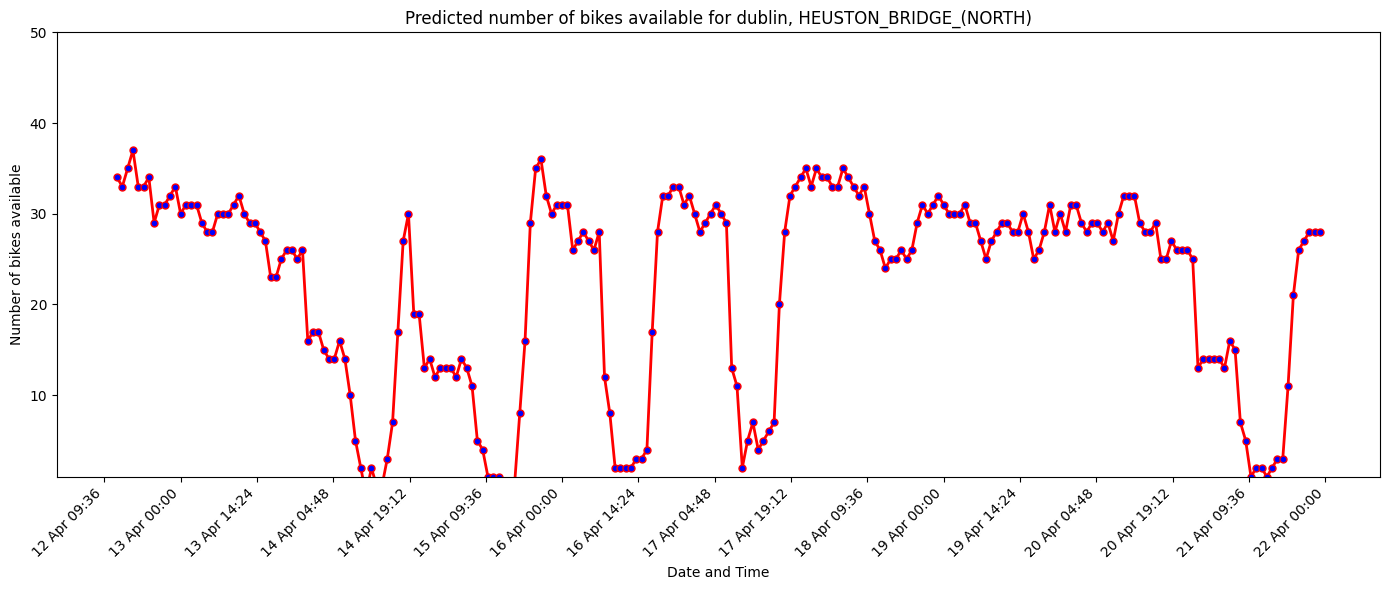

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |                                     | Rows 0/228 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 30.26% |█████████▍                     | Rows 69/228 | Elapsed Time: 00:01 | Remaining Time: 00:02

Uploading Dataframe: 100.00% |█████████████████████████████| Rows 228/228 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: bike_availability_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions


2025-04-12 09:41:16,919 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED


2025-04-12 09:41:20,123 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-04-12 09:43:15,586 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-04-12 09:43:15,744 INFO: Waiting for log aggregation to finish.


2025-04-12 09:43:27,729 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [15]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-24 03:00:00+00:00,11.30,5.056276,1.9,0.0,41.104683,30634.960938,7.5,dublin,1,4,3,41,18
1,2025-01-23 01:00:00+00:00,4.65,1.574594,0.0,0.0,11.019764,30442.521484,2.9,dublin,1,3,1,39,15
2,2025-01-25 05:00:00+00:00,1.30,-4.210609,0.0,0.0,20.326454,30829.769531,2.1,dublin,1,5,5,41,19
3,2025-01-27 04:00:00+00:00,5.60,1.149379,0.1,0.0,17.418196,31225.949219,8.4,dublin,1,0,4,30,16
4,2025-01-24 10:00:00+00:00,5.55,-3.144419,0.0,0.0,45.814861,30634.960938,6.0,dublin,1,4,10,34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2025-04-13 11:00:00+00:00,9.60,5.626809,0.1,0.0,15.038350,50003.859375,0.9,dublin,4,6,11,32,24
253,2025-04-12 19:00:00+00:00,11.35,9.830602,0.0,0.0,7.200000,49754.738281,0.3,dublin,4,5,19,29,8
254,2025-04-12 15:00:00+00:00,13.45,11.949957,0.0,0.0,6.489992,49754.738281,0.3,dublin,4,5,15,37,4
255,2025-04-12 20:00:00+00:00,10.60,8.080139,0.0,0.0,12.496719,49754.738281,0.3,dublin,4,5,20,31,9


In [16]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()

bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.25s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
11513,2025-02-02 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
11514,2025-02-18 06:00:00+00:00,HEUSTON_BRIDGE_(NORTH),30.0
11515,2025-03-01 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
11516,2025-03-31 06:00:00+00:00,HEUSTON_BRIDGE_(NORTH),37.0


In [17]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.600000,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.900000,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.500000,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.300000,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.000000,dublin
...,...,...,...,...,...,...,...,...,...
13171,2025-04-16 22:00:00+00:00,6.2500,3.747705,0.0,0.0,7.517021,50741.484375,2.400000,dublin
13172,2025-04-15 18:00:00+00:00,9.3500,5.620005,0.1,0.0,16.039202,50497.425781,1.200000,dublin
13173,2025-04-18 19:00:00+00:00,8.7500,6.647379,0.0,0.0,6.792466,51226.128906,6.099999,dublin
13174,2025-04-14 15:00:00+00:00,12.1000,7.841188,0.1,0.0,19.228851,50251.484375,2.700000,dublin


In [18]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [19]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

233


,datetime,predicted_bikes_available,num_bikes_available
208,2024-12-28 01:00:00+00:00,39,39.0
191,2024-12-28 02:00:00+00:00,40,39.0
201,2024-12-28 03:00:00+00:00,40,39.0
185,2024-12-28 04:00:00+00:00,39,39.0
193,2024-12-28 05:00:00+00:00,38,39.0
...,...,...,...
232,2025-02-01 15:00:00+00:00,25,37.0
216,2025-02-01 16:00:00+00:00,23,37.0
221,2025-02-01 17:00:00+00:00,22,33.0
223,2025-02-01 18:00:00+00:00,26,36.0


In [20]:
outcome_df = outcome_df.sort_values(by=['datetime'])
outcome_df

,datetime,num_bikes_available
5695,2023-08-07 02:00:00+00:00,10.0
2161,2023-08-07 03:00:00+00:00,10.0
3422,2023-08-07 04:00:00+00:00,10.0
8312,2023-08-07 05:00:00+00:00,10.0
2192,2023-08-07 06:00:00+00:00,10.0
...,...,...
11320,2025-04-11 20:00:00+00:00,38.0
10798,2025-04-11 21:00:00+00:00,39.0
9938,2025-04-11 22:00:00+00:00,39.0
9961,2025-04-11 23:00:00+00:00,39.0


In [21]:
preds_df = preds_df.sort_values(by=['datetime'])
preds_df

,datetime,predicted_bikes_available
208,2024-12-28 01:00:00+00:00,39
191,2024-12-28 02:00:00+00:00,40
201,2024-12-28 03:00:00+00:00,40
185,2024-12-28 04:00:00+00:00,39
193,2024-12-28 05:00:00+00:00,38
...,...,...
240,2025-04-13 07:00:00+00:00,30
238,2025-04-13 08:00:00+00:00,30
235,2025-04-13 09:00:00+00:00,30
243,2025-04-13 10:00:00+00:00,31


In [22]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  233


,datetime,predicted_bikes_available,num_bikes_available
208,2024-12-28 01:00:00+00:00,39,39.0
191,2024-12-28 02:00:00+00:00,40,39.0
201,2024-12-28 03:00:00+00:00,40,39.0
185,2024-12-28 04:00:00+00:00,39,39.0
193,2024-12-28 05:00:00+00:00,38,39.0
...,...,...,...
232,2025-02-01 15:00:00+00:00,25,37.0
216,2025-02-01 16:00:00+00:00,23,37.0
221,2025-02-01 17:00:00+00:00,22,33.0
223,2025-02-01 18:00:00+00:00,26,36.0


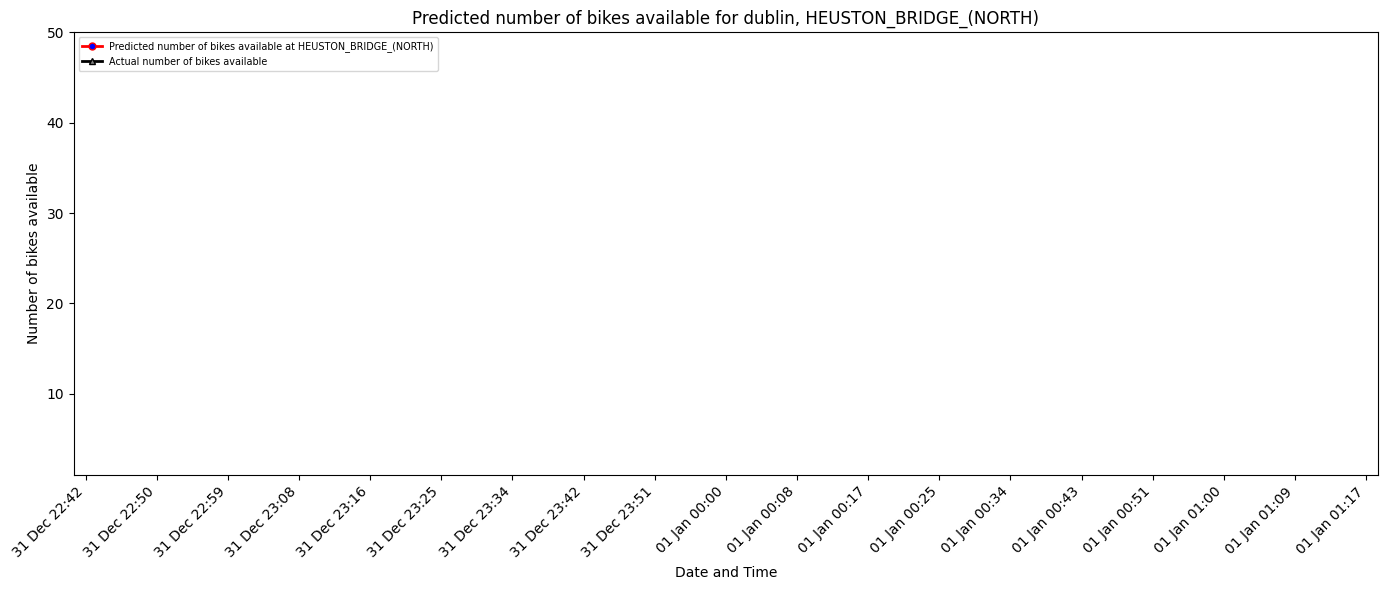

In [23]:
file_path = "docs/bike_availability_hindcast_10days.png"
import pytz

today = datetime.datetime.now(pytz.utc)
hindcast_df_10days = hindcast_df[hindcast_df['datetime'] >= today - datetime.timedelta(days=10)]

plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df_10days, file_path, hindcast=True)
plt.show()